### Load Data

In [1]:
import pandas as pd
import numpy as np

# Make sure it prints the whole array
np.set_printoptions(threshold=np.inf)

df = pd.read_parquet("../data/raw/guitar_sample_parquet")
df.head()

,video_id,title,description,tags,publishedAt,channelTitle,viewCount,likeCount,duration,raw_snippet,raw_statistics,level,topic
0,4WVkDrb6d5A,"A Good, Quick Intermediate Guitar Lesson",Trying to combine a few concepts into one flui...,"[guitar, sean daniel, guitar lesson, sean dani...",2021-08-15T13:00:02Z,Sean Daniel,163929,3868.0,PT12M41S,"{'categoryId': '10', 'channelId': 'UCzZCiVjRPP...","{'commentCount': '148', 'favoriteCount': '0', ...",intermediate,Learning songs
1,WN4IoK7ecAU,How to Teach Yourself Guitar in 2026 (Save YEA...,Are you part of the 90% of aspiring guitarists...,"[O.R.-Guitar, how to play, guitar lesson, guit...",2024-02-05T04:46:37Z,Oryam Bisset,3968428,202324.0,PT10M40S,"{'categoryId': '10', 'channelId': 'UCXUJSxAjaQ...","{'commentCount': '4546', 'favoriteCount': '0',...",beginner,Chords
2,-iV-7XhUMT0,Are You An Intermediate Or Advanced Guitar Pla...,More Guitar Resources:\n🎵 Get my FREE Guitar G...,"[Marty Schwartz, music, guitar, marty music, g...",2020-09-25T14:00:00Z,Marty Music,165635,4986.0,PT10M7S,"{'categoryId': '10', 'channelId': 'UCmnlTWVJys...","{'commentCount': '962', 'favoriteCount': '0', ...",intermediate,Chords
3,wH63GHXTHgU,Advanced Chords Practice Routine - Guitar Less...,"Gain access to TABS, exclusive tutorials and o...","[jazz guitar chords, advanced guitar chords le...",2020-05-05T14:46:45Z,swiftlessons,434634,14417.0,PT16M8S,"{'categoryId': '10', 'channelId': 'UCjdxyPMmti...","{'commentCount': '346', 'favoriteCount': '0', ...",beginner,Chords
4,kNgpKxHo0H4,Memorize the Fretboard in 3 MINUTES!,Fretboard memorization is an essential part of...,"[notes on guitar fretboard, fretboard memoriza...",2021-01-06T20:31:18Z,Redlight Blue,4772989,328588.0,PT4M1S,"{'categoryId': '10', 'channelId': 'UCojVsOfwIR...","{'commentCount': '4172', 'favoriteCount': '0',...",intermediate,Chords


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   video_id        1270 non-null   object 
 1   title           1270 non-null   object 
 2   description     1270 non-null   object 
 3   tags            1270 non-null   object 
 4   publishedAt     1270 non-null   object 
 5   channelTitle    1270 non-null   object 
 6   viewCount       1270 non-null   int64  
 7   likeCount       1261 non-null   float64
 8   duration        1270 non-null   object 
 9   raw_snippet     1270 non-null   object 
 10  raw_statistics  1270 non-null   object 
 11  level           1270 non-null   object 
 12  topic           1270 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 129.1+ KB


In [3]:
# Check how many unknowns
df["level"].value_counts()

level
intermediate    747
beginner        486
advance          37
Name: count, dtype: int64

In [4]:
# # Map ordinal labels to numbers
# level_map = {"beginner": 1, "intermediate": 2, "advance": 3}
# df["level_rank"] = df["level"].map(level_map)

# Preparing the Data

In [5]:
from sklearn.model_selection import train_test_split

text_features = ["title", "description"]

X = df[text_features].copy() # copying to appease the tfidfvectorizer
y = df["level"]

# Concatenate each text column into one column
X['text'] = df[text_features].apply(
    lambda x: " ".join(x.astype(str)),
    axis=1
)
X = X[['text']] # return the text feature as a dataframe

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.2)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1016, 1), (254, 1), (1016,), (254,))

# Text Vectorization (TF-IDF)

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train = X_train["text"]
X_val = X_val["text"]

vectorizer = TfidfVectorizer(max_features=10000, stop_words=None, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

print(X_train_tfidf.shape)
print(len(y_train))

(1016, 10000)
1016


In [7]:
feature_names = vectorizer.get_feature_names_out()

feature_embedded_df = pd.DataFrame(
    data=X_train_tfidf.toarray(),
    columns=feature_names
)

feature_embedded_df.head()

,00,00 00,00 having,00 intro,00 introduction,00 lesson,00 lick,00 value,000,000 15m,...,zinda hoon,zindagi,zombie,zombie guitar,zombie on,zombie the,zoom,zoom h1n,zxajrm,zxajrm magnatone
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.169729,0.0,0.0,0.0,0.0,0.0,0.0,0.300274,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modeling & Evaluation

### Model 0: Baseline
**Logistic Regression (Default TF-IDF)**

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

lr_model = LogisticRegression()

lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_val_tfidf)

In [9]:
labels = ["beginner", "intermediate", "advance"]

accuracy = accuracy_score(y_val, y_pred_lr)
precision = precision_score(y_val, y_pred_lr, average='weighted')
cm = confusion_matrix(y_val, y_pred_lr, labels=labels)


In [10]:
y_val

1214    intermediate
1161    intermediate
422     intermediate
976     intermediate
793         beginner
            ...     
163     intermediate
486     intermediate
626     intermediate
221     intermediate
243     intermediate
Name: level, Length: 254, dtype: object

In [11]:

cm_df = pd.DataFrame(data=cm, index=labels, columns=labels)

print(cm_df)

              beginner  intermediate  advance
beginner            88             5        0
intermediate         1           149        0
advance              0             9        2


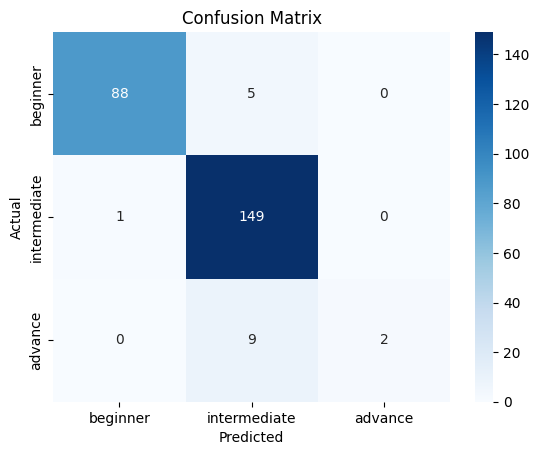

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# print accuracy, precision, and confusion matrix
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"confusion_matrix: {cm_df}")

accuracy: 0.9409448818897638
precision: 0.945163860617926
confusion_matrix:               beginner  intermediate  advance
beginner            88             5        0
intermediate         1           149        0
advance              0             9        2


#### Run on Test Data

In [14]:
test_df = pd.read_csv("../data/raw/guitar_sample_test_2.csv")
test_df.head()

,Unnamed: 0,video_id,title,description,tags,publishedAt,channelTitle,viewCount,likeCount,duration,raw_snippet,raw_statistics,level,topic
0,1,sDjeY1jI2Z8,5 GREAT chord tricks everyone should know!,▶MY NEW COURSE◀ http://nextlevelplaying.com\nK...,"['paul davids', 'acoustic', 'great', 'tricks',...",2020-03-14T16:59:33Z,Paul Davids,2611079,106425.0,PT14M21S,"{'publishedAt': '2020-03-14T16:59:33Z', 'chann...","{'viewCount': '2611079', 'likeCount': '106425'...",unknown,Chords
1,5,WJM4NC7Jgf8,4 levels of chords progression #guitarchords,Guitar: GJA-SG200 by Sigma\nTabs and other les...,"['guitarchords', 'guitarteacher', 'guitarlesso...",2024-09-24T18:40:25Z,Anton Glushkin,9081639,381958.0,PT43S,"{'publishedAt': '2024-09-24T18:40:25Z', 'chann...","{'viewCount': '9081639', 'likeCount': '381958'...",unknown,Chords
2,9,o-qNepGpI3U,MUSIC THEORY for guitar,"Here’s an even better offer, join my weekly le...",[],2024-11-22T18:32:04Z,samuraiguitarist,804505,43203.0,PT18M26S,"{'publishedAt': '2024-11-22T18:32:04Z', 'chann...","{'viewCount': '804505', 'likeCount': '43203', ...",unknown,Chords
3,19,emdoZDHlUsI,Learn these 4 R&B chords!,NaN,[],2024-05-31T18:41:22Z,JUNO The Artist,318222,8119.0,PT16S,"{'publishedAt': '2024-05-31T18:41:22Z', 'chann...","{'viewCount': '318222', 'likeCount': '8119', '...",unknown,Chords
4,20,JRgBkv_N9PY,🎸This 2-Step Guitar Drill Unlocks the Entire F...,Want to master the entire guitar fretboard? 🎸 ...,"['Guitar Tips', 'Power Chords', 'Open Chords',...",2025-02-02T18:34:21Z,Billman 🎸👍,521223,21717.0,PT1M,"{'publishedAt': '2025-02-02T18:34:21Z', 'chann...","{'viewCount': '521223', 'likeCount': '21717', ...",unknown,Chords


In [15]:
X_test_df= test_df[text_features].copy() # copying to appease the tfidfvectorizer

# Concatenate each text column into one column
X_test_df['text'] = X_test_df[text_features].apply(
    lambda x: " ".join(x.astype(str)),
    axis=1
)
X_test = X_test_df['text'] # return the text feature as a dataframe
X_test_tfidf = vectorizer.transform(X_test)

y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_lr.shape

(583,)

In [16]:
test_df["level_predicted"] = y_pred_lr
test_df.to_csv("../data/processed/guitar_sample_predicted.csv")

### Model 1a: Feature-Tuned Linear Model
**Logistic Regression with Optimized TF-IDF**

In [46]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=1000))
])
    
param_grid = {
    "tfidf__max_features": [1000, 2500, 5000, 10000, 20000, 28000],
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__stop_words": [None, 'english']
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

({'tfidf__max_features': 28000,
  'tfidf__ngram_range': (1, 2),
  'tfidf__stop_words': None},
 0.8384978729290158)

In [47]:
best_model = grid.best_estimator_

best_model.fit(X_train, y_train)

y_pred_grid = best_model.predict(X_val)

In [48]:
accuracy = accuracy_score(y_val, y_pred_grid)
precision = precision_score(y_val, y_pred_grid, average='weighted')
cm = confusion_matrix(y_val, y_pred_grid, labels=labels)

In [49]:
# print accuracy, precision, and confusion matrix
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"confusion_matrix: {cm}")

accuracy: 0.9645669291338582
precision: 0.9659614455668737
confusion_matrix: [[ 93   0   0]
 [  0 150   0]
 [  2   7   2]]


### Model 1b: Fully Tuned Linear Model
**Logistic Regression with Optimized TF-IDF + Regularization**

### Model 1c: Ordinal Linear Model
**Ordinal Logistic Regression (Optimized TF-IDF)**

### Model 2: Probabilistic Models
**Naive Bayes Classifier**

### Model 3: Tree-Based Models
**Random Forest Classifier**

### Model 4: Boosted Tree Models
**Gradient Boosting / XGBoost Classifier**

In [17]:
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.metrics import mean_squared_error, r2_score

# models = {
#     "naive_bayes": MultinomialNB(),
#     "linear_regression": LinearRegression(),
#     "random_forest_reg": RandomForestRegressor()
# }

# for name, model in models.items():
#     model.fit(X_train_tfidf, y_train)
#     y_pred = model.predict(X_val_tfidf)#np.clip(np.round(),1, 3)
#     print(f"{name}_score: {model.score(X=X_val_tfidf, y=y_val)}")
#     print(f"{name}_RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}")
#     print(f"{name}_R2 Score: {r2_score(y_val, y_pred)}")
#     print("Predictions:", y_pred)
    

In [ ]:
# from sentence_transformers import SentenceTransformer

# sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')
# X_train_embed = sentence_transformer.encode(X_train.to_list())
# X_val_embed = sentence_transformer.encode(X_val.to_list())

# print(X_train_embed.shape)
# print(len(y_train))|

In [19]:
# for name, model in models.items():
#     if name == "naive_bayes":
#         continue
#     model.fit(X_train_embed, y_train)
#     y_pred = model.predict(X_val_embed)
#     y_pred = np.round(y_pred)
#     print(f"{name}_score: {model.score(X=X_val_embed, y=y_val)}")
#     print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))
#     print("R2 Score:", r2_score(y_val, y_pred))
#     print("Predictions:", y_pred)

In [20]:
# !pip install -U sentence-transformers

In [21]:
# test_df = level_unknown_df.copy()

# test_df.to_csv("../data/raw/guitar_sample_test.csv")

In [22]:
# level_map = {"beginner": 1, "intermediate": 2, "advanced": 3}

# train_level_labels = train_df["level"].map(level_map).to_list()
# val_level_labels = val_df["level"].map(level_map).to_list()

# print(train_level_labels)

In [23]:
# train_topic_labels = train_df["topic"]
# val_topic_labels = val_df["topic"]
# test_topic_labels = test_df["topic"]
# print('\n'.join(train_topic_labels))

In [24]:
# train_df["title_desc"] = train_df["title"] + " " + train_df["description"]
# val_df["title_desc"] = val_df["title"] + " " + val_df["description"]
# test_df["title_desc"] = test_df["title"] + " " + test_df["description"]

In [25]:
# train_lesson_texts = train_df["title_desc"]
# val_lesson_texts = val_df["title_desc"]
# test_lesson_texts = test_df["title_desc"]
# len(train_lesson_texts), len(val_lesson_texts), len(test_lesson_texts)

In [26]:
# train_level_one_hot = one_hot_encoder.fit_transform(np.array(train_level_labels).reshape(-1, 1))
# val_level_one_hot = one_hot_encoder.fit_transform(np.array(val_level_labels).reshape(-1, 1))
# test_level_one_hot = one_hot_encoder.fit_transform(np.array(test_level_labels).reshape(-1, 1))

# train_level_one_hot

In [27]:
# one_hot_encoder = OneHotEncoder(sparse_output=False)

# train_topic_one_hot = one_hot_encoder.fit_transform(train_topic_labels)
# val_topic_one_hot = one_hot_encoder.fit_transform(val_topic_labels)
# test_topic_one_hot = one_hot_encoder.fit_transform(test_topic_labels)

# train_topic_one_hot